# Download dataset

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="C0XAEXYeZ6d5uRXrFr1g")
project = rf.workspace("truong-a6rzc").project("bien-bao-giao-thong-viet-nam-zalo")
version = project.version(1)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bien-bao-giao-thong-viet-nam-zalo-1 in folder:: 100%|██████████| 4396/4396 [00:01<00:00, 2456.42it/s]


# Import libraries

In [ ]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import pandas as pd
import os

In [ ]:
# set torch device to available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.device(device)

Using cuda device


device(type='cuda')

# Data preprocessing

## Split dataset into format:
```dataset/
    train/
        class_1/
            image1.jpg
            ...
        class_2/
            ...
    val/
        class_1/
            ...
        class_2/
            ...
    test/
        class_1/
            ...
        class_2/
            ...

            

In [ ]:
import os
import shutil
import random
from pathlib import Path

def split_dataset(dataset_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    random.seed(seed)

    dataset_dir = Path(dataset_dir)
    output_dir = Path(output_dir)
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."

    for class_dir in dataset_dir.iterdir():
        if not class_dir.is_dir():
            continue
        images = list(class_dir.glob("*.*"))  # Match all image files
        random.shuffle(images)

        total = len(images)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        subsets = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for subset, subset_images in subsets.items():
            subset_class_dir = output_dir / subset / class_dir.name
            subset_class_dir.mkdir(parents=True, exist_ok=True)
            for img_path in subset_images:
                shutil.copy(img_path, subset_class_dir / img_path.name)

    print(f"Dataset split completed and saved to {output_dir}")


split_dataset("/content/bien-bao-giao-thong-viet-nam-zalo-1/train", "/content/dataset", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)


Dataset split completed and saved to /content/dataset


## Check original image size

In [ ]:
from PIL import Image
image = Image.open("/content/dataset/test/101_DuongCam/10-Copy-2-_JPG.rf.3323eb51c77bdf8d2f47a6550d3e2957.jpg")
image.size

(640, 640)

## Augment training set and resize images to 64x64 pixels

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ImageNet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Augmentations for training set
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# No augmentation for val/test
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load datasets
train_dataset = datasets.ImageFolder("/content/dataset/train", transform=train_transform)
val_dataset = datasets.ImageFolder("/content/dataset/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder("/content/dataset/test", transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# Visualize a sample of each set

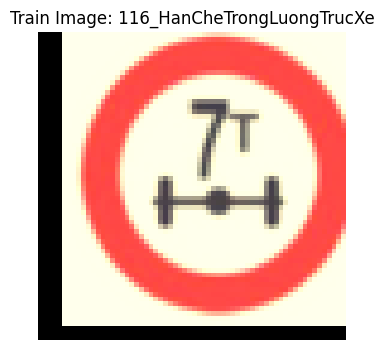

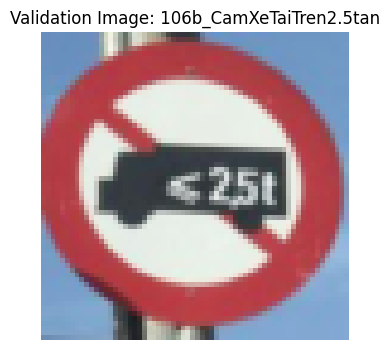

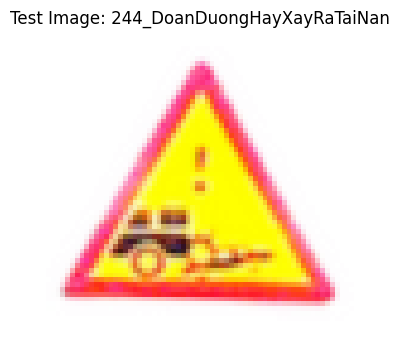

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

def show_random_image(dataset, mean, std, title=''):
    idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[idx]
    img = unnormalize(img, mean, std).permute(1, 2, 0).numpy()
    label_name = dataset.classes[label]

    plt.figure(figsize=(4, 4))
    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"{title}: {label_name}")
    plt.axis('off')
    plt.show()

show_random_image(train_dataset, mean, std, title="Train Image")
show_random_image(val_dataset, mean, std, title="Validation Image")
show_random_image(test_dataset, mean, std, title="Test Image")


## Check number of labels in the dataset

In [ ]:
len(train_dataset.classes), len(val_dataset.classes), len(test_dataset.classes)

(121, 121, 121)

# Build a CNN model

## Model architecture

In [ ]:
import torch
import torch.nn as nn

class VNTSClassifier(nn.Module):
    def __init__(self, num_classes=121):
        super(VNTSClassifier, self).__init__()
        torch.manual_seed(42)

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),  # 64 → 32

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),  # 32 → 16

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),  # 16 → 8

            # Block 4 (bottleneck)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


In [ ]:
# create model instance
model = VNTSClassifier().to(device)

## Define optimizer, loss function, scheduler

In [ ]:
# create optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# create scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training

## Train, evaluation loop

In [ ]:
def train(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    training_loss = []
    validation_loss = []

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        # model training
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            # zero grad
            optimizer.zero_grad()

            # forward pass
            output = model(images)
            loss = loss_fn(output, labels)

            # backward pass
            loss.backward()
            optimizer.step()

            # total loss
            train_loss += loss.item()

        # model evaluation
        model.eval()

        # using no_grad / inference
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to GPU
                output = model(images)
                loss = loss_fn(output, labels)
                val_loss += loss.item()

        train_loss /= len(train_loader)  # calculate avg loss
        val_loss /= len(val_loader)  # calculate avg loss

        # append data
        training_loss.append(train_loss)
        validation_loss.append(val_loss)

        # print loss per epoch
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

        # Step the scheduler if defined
        if scheduler:
            scheduler.step()

    return training_loss, validation_loss

## Train!!!

In [ ]:
training_loss, validation_loss = train(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=20)

Epoch 1/20 - Training Loss: 3.9891 - Validation Loss: 3.0315
Epoch 2/20 - Training Loss: 2.9967 - Validation Loss: 2.3657
Epoch 3/20 - Training Loss: 2.2440 - Validation Loss: 1.8097
Epoch 4/20 - Training Loss: 1.5875 - Validation Loss: 1.2114
Epoch 5/20 - Training Loss: 1.1345 - Validation Loss: 0.8496
Epoch 6/20 - Training Loss: 0.7631 - Validation Loss: 0.6441
Epoch 7/20 - Training Loss: 0.5641 - Validation Loss: 0.4309
Epoch 8/20 - Training Loss: 0.4460 - Validation Loss: 0.3947
Epoch 9/20 - Training Loss: 0.3685 - Validation Loss: 0.2831
Epoch 10/20 - Training Loss: 0.3264 - Validation Loss: 0.2747
Epoch 11/20 - Training Loss: 0.2418 - Validation Loss: 0.1982
Epoch 12/20 - Training Loss: 0.2158 - Validation Loss: 0.1842
Epoch 13/20 - Training Loss: 0.2105 - Validation Loss: 0.1726
Epoch 14/20 - Training Loss: 0.1972 - Validation Loss: 0.1800
Epoch 15/20 - Training Loss: 0.1910 - Validation Loss: 0.1622
Epoch 16/20 - Training Loss: 0.1948 - Validation Loss: 0.1582
Epoch 17/20 - Tra

## Plot training and validation loss

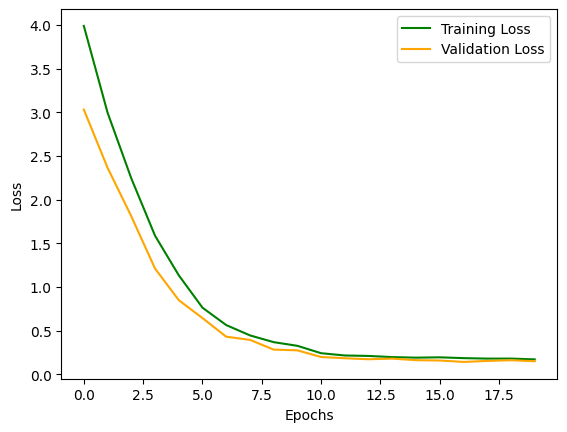

In [ ]:
# visualize loss
plt.plot(training_loss, label='Training Loss', color='green')
plt.plot(validation_loss, label='Validation Loss',color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluate

## Predict on test set

In [ ]:
def predict(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the same device as the data

    model.eval()
    test_labels = []
    predicted_labels = []

    with torch.no_grad():  # Use torch.no_grad() for inference to save memory
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            output = model(images)
            _, predicted = torch.max(output, 1)  # Get the index of the max log-probability

            test_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy array
            predicted_labels.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy array

    return test_labels, predicted_labels

In [ ]:
# test model
test_labels, predicted_labels = predict(model, test_loader)


## Evaluation metrics

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, precision_score, recall_score

# print accuracy , f1score ,precision scre ,recall score
print("Accuracy:", accuracy_score(test_labels, predicted_labels))
print("F1 Score:", f1_score(test_labels, predicted_labels, average='weighted'))
print("Precision:", precision_score(test_labels, predicted_labels, average='weighted'))
print("Recall:", recall_score(test_labels, predicted_labels, average='weighted'))

# print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))




Accuracy: 0.9289827255278311
F1 Score: 0.9120601727127639
Precision: 0.9068412393748285
Recall: 0.9289827255278311
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.50      0.20      0.29         5
           4       0.50      0.80      0.62         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00        

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Inference on random images from internet

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np

def predict_image(image_path, model, class_names, mean, std, image_size=(64, 64)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Define transform
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    # Plot the image with predicted label
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class


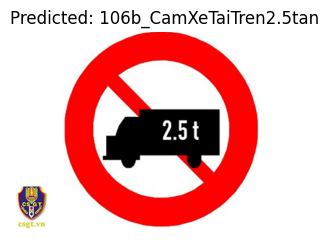

Predicted Label: 106b_CamXeTaiTren2.5tan


In [ ]:
image_path = "/content/taixe-1511251917_680x0.jpg"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


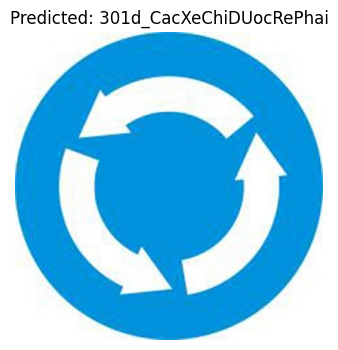

Predicted Label: 301d_CacXeChiDUocRePhai


In [ ]:
image_path = "/content/R303.jpg"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


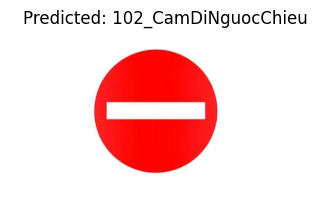

Predicted Label: 102_CamDiNguocChieu


In [ ]:
image_path = "/content/bien-bao-cam.webp"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


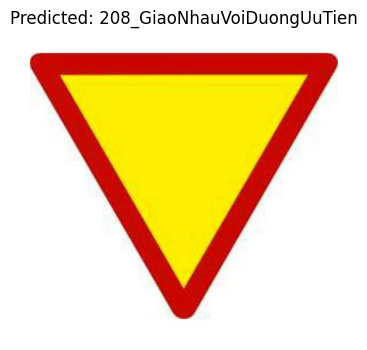

Predicted Label: 208_GiaoNhauVoiDuongUuTien


In [ ]:
image_path = "/content/bien-bao-giao-nhau-voi-duong-uu-tien.webp"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


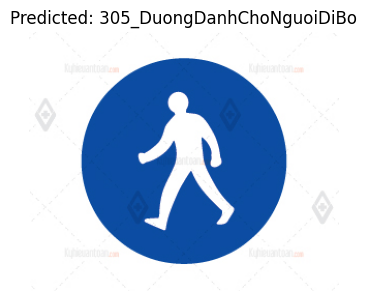

Predicted Label: 305_DuongDanhChoNguoiDiBo


In [ ]:
image_path = "/content/bien-305-binh-duong-danh-cho-nguoi-dibo-bien-chi-dan-bien-hieu-lenh-bien-bao-giao-thong-phan-quang-gia-re-14.jpg"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


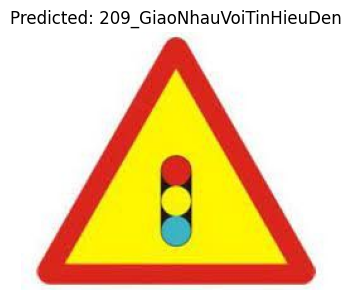

Predicted Label: 209_GiaoNhauVoiTinHieuDen


In [ ]:
image_path = "/content/bien-bao-giao-thong-giao-nhau-co-tin-hieu-den-w209-1-0x0.jpg"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


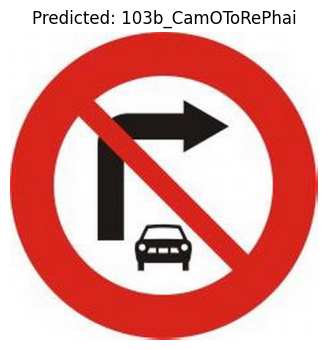

Predicted Label: 103b_CamOToRePhai


In [ ]:
image_path = "/content/103b.jpg"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


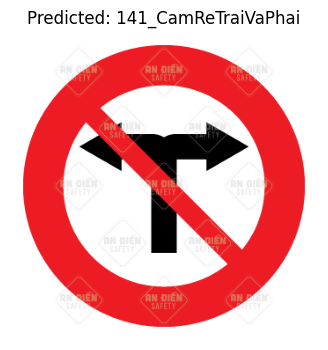

Predicted Label: 141_CamReTraiVaPhai


In [ ]:
image_path = "/content/12.png"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


# Save model

In [ ]:
torch.save(model.state_dict(), 'vntsc_v2.pth')

In [ ]:
from google.colab import files
files.download('/content/vntsc_v2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>